**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

/home/ubuntu/fastai/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

Split dataframe in train and validation:

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

Define root mean square error and function to print score

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=16, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3min 6s, sys: 1.44 s, total: 3min 8s
Wall time: 18.3 s
[0.11904915769434025, 0.2273152076858351, 0.9703798345469747, 0.9077205585566838, 0.9118508161309987]


###### Trick if RandomForrestRegressor should run multiple times -  Or just good practice

Each time the RandomForestRegressor is launch it will convert our elements into dtype=np.float32. Therefore, if we do this once, we are able to save this operation each time we run the RandomForestregressor, hence save time if the RandomForestRegressor is conducted multiple times. 

In [10]:
%time x=np.array(X_train, dtype=np.float32)

CPU times: user 1.16 s, sys: 312 ms, total: 1.48 s
Wall time: 1.47 s


In [11]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(x, y_train)
print_score(m)

CPU times: user 3min 3s, sys: 399 ms, total: 3min 4s
Wall time: 16.5 s
[0.11926154803149164, 0.22853691794285513, 0.9702740522158878, 0.9067259775111615, 0.9115595138248296]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [12]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.68 s, sys: 40 ms, total: 1.72 s
Wall time: 1.72 s


(9.202173839710435, 0.16643202402265922)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [13]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 396 ms, sys: 226 ms, total: 622 ms
Wall time: 925 ms


(9.202173839710435, 0.16643202402265922)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

We create a new dataframe based on our validation set and add the two columns "standard deviation" and "prediction" to it. Next, we plot the "Enclosure" feature as a function of observations in form om a boxdiagram.   

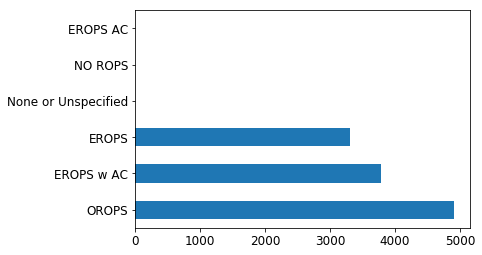

In [14]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

As see above only three values is used in this feature. Where OROPS have most observations. 

Addtionally, we use show the mean of the actual saleprice, our predictions and the standard deviation grouped by Enclosure.

In [15]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby(flds[0], as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.832275,0.248355
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.589618,0.230727
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685055,0.204131


The above table can be depicted as barplot as below:

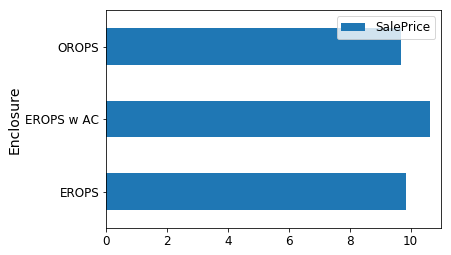

In [16]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

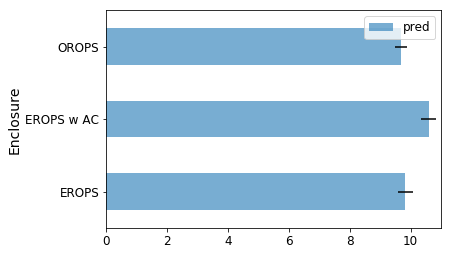

In [17]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

Caculating the ratio between the standard deviation and the predtions, will tell us where the predictions are less accurate. 

In [18]:
enc_summ = x[flds].groupby(flds[0]).mean()
(enc_summ.pred_std/enc_summ.pred).sort_values(ascending=False)

Enclosure
EROPS                  0.025259
EROPS w AC             0.021788
OROPS                  0.021077
EROPS AC                    NaN
NO ROPS                     NaN
None or Unspecified         NaN
dtype: float64

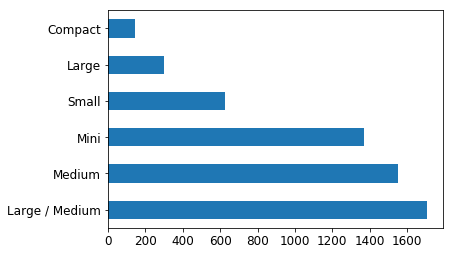

In [19]:
raw_valid.ProductSize.value_counts().plot.barh();

In [20]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby('ProductSize',as_index=False).mean()
summ

,ProductSize,SalePrice,pred,pred_std
0,Compact,9.735093,9.822147,0.286130
1,Large,10.470589,10.412845,0.335797
2,Large / Medium,10.691871,10.655553,0.270745
3,Medium,10.681511,10.626145,0.248058
4,Mini,9.535147,9.547340,0.216901
5,Small,10.324448,10.337266,0.266097


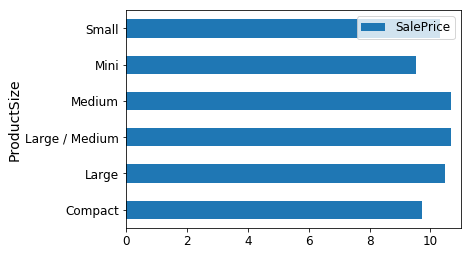

In [21]:
summ = summ[~pd.isnull(summ.SalePrice)]
summ.plot(flds[0], 'SalePrice', 'barh', xlim=(0,11));

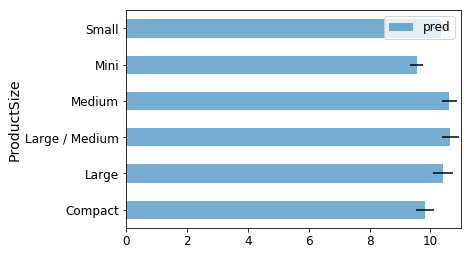

In [22]:
summ.plot(flds[0],'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

Caculating the ratio between the standard deviation and the predtions, will tell us where the predictions are less accurate. 

In [23]:
summ = x[flds].groupby('ProductSize').mean()
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.032248
Compact           0.029131
Small             0.025742
Large / Medium    0.025409
Medium            0.023344
Mini              0.022719
dtype: float64

# Feature importance - usually first thing to look at! 

Normally in industry and academic enviroment feature importance is usually observed in some kind of linear regression, logistic regression or general linear models. Using these models, one take note of the coefficients and depending on their magnitude the importance of is observed. There is this trop out there that this is somehow more accurate, more pure, in some way better way of doing feature importance, but that couldn’t be farther from the truth

If you think about it, if you were missing an interaction, if you were missing a transformation you needed, or if you have any way being anything less than a 100% perfect in all of your pre-processing so that your model is the absolute correct truth of the situation — unless you’ve got all of that correct, then your coefficients are wrong. Your coefficients are telling you “in your totally wrong model, this is how important those things are” which is basically meaningless. 

Where else, the random forest feature importance is telling you in this extremely high parameter, highly flexible functional form, with few if any statistical assumptions, this is your feature importance. 

Therefore, be very cautions about logistic regression coefficients. Furthermore, if they’ve done so much pre-processing that actually the model is pretty accurate then now you are looking at coefficients that are going to be like a coefficient of some principal component from a PCA or a coefficient of some distance from some cluster or something. At which point, they are very very hard to interpret anyway. They are not actual variables. So they are kind of the two options I’ve seen when people try to use classic statistical techniques to do a variable importance equivalent.

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [24]:
fi = rf_feat_importance(m, X_train); fi[:11]

,cols,imp
5,YearMade,0.165033
37,Coupler_System,0.084722
14,fiProductClassDesc,0.084454
13,ProductSize,0.083447
39,Hydraulics_Flow,0.081592
2,ModelID,0.054048
63,saleElapsed,0.052461
10,fiSecondaryDesc,0.048028
19,Enclosure,0.037784
38,Grouser_Tracks,0.035728


https://pandas.pydata.org/pandas-docs/version/0.15.2/generated/pandas.DataFrame.plot.html

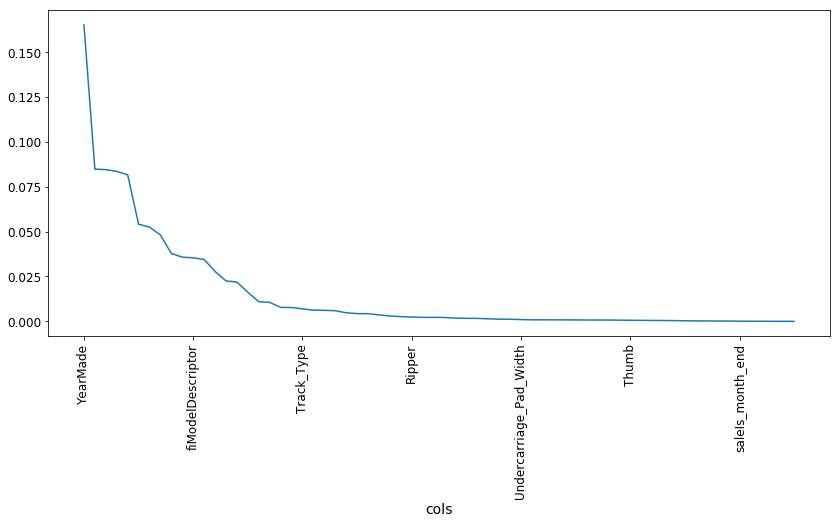

In [25]:
fi.plot('cols', 'imp', figsize=(14,6), legend=False, rot=90);

In [26]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

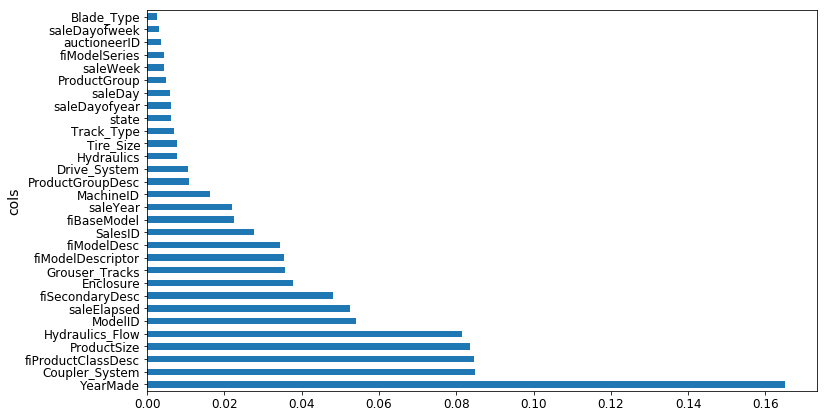

In [27]:
plot_fi(fi[:30]);

In the above plot look for the natural break ad study the most important features carefully! Consult we others aboute this features as figure out if there is something we can do sharpen these features! (reduce noise etc). Furthermore, make sure that it make sense that these features are the most important.

As seen above only a dosen features are of importance. Therefore, for speeding things up we want to discard those featurs that have less than 0.5% importants for the RandomForestRegressor.  

In [28]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [29]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

After creating a new X_train we run our RandomForestRegressor once again.

In [30]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 58s, sys: 472 ms, total: 1min 58s
Wall time: 10.5 s
[0.1241537625288163, 0.22482921056641822, 0.967785262475744, 0.909727920881748, 0.9098114502342785]


By discarding redundant features we have almost half the CPU times. Furthermore, we have improved our model a bit, as we have making spilting easier for the regressor by removeing redundant features. 

Previous results:
CPU times: user 3min 24s, sys: 509 ms, total: 3min 25s
Wall time: 17.9 s
[0.11920303508749704, 0.22833011540109185, 0.9703032137697971, 0.906894708039957, 0.9116337392845516]

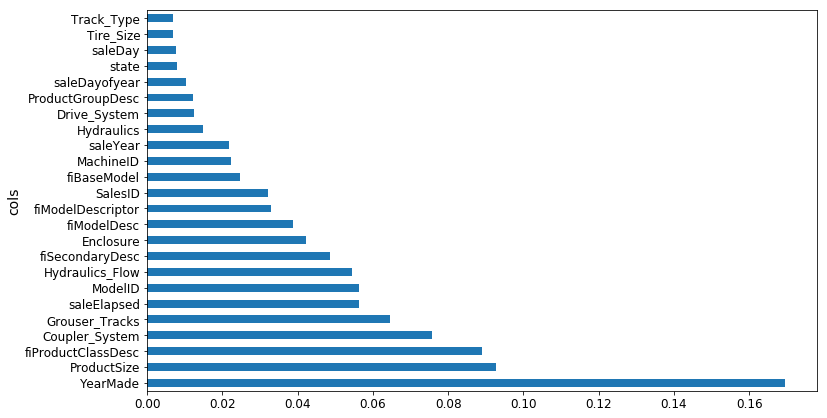

In [31]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi);

Key thing that has happened is that when you remove redundant columns, you are also removing sources of collinearity. In other words, two columns that might be related to each other. Collinearity does not make your random forests less predictive, but if you have a column A is a little bit related to a column B, and B is a strong driver of the independent, what happens is that the importance is going to be split between A and B. By removing some of those columns with very little impact, it makes your feature importance plot clearer. Before YearMade was pretty close to Coupler_System. But there must have been a bunch of things that are collinear with YearMade and now you can see YearMade really matters. This feature importance plot is more reliable than the one before because it has a lot less collinearity to confuse us.

#### rf_feat_importance

Interestingly, almost no one knows this. Many people will tell you there is no way of interpreting this particular kind of model (the most important interpretation of a model is knowing which things are important) and that is almost certainly not going to be true because the technique I am going to teach you actually works for any kind of models.

- We take our bulldozer data set and we have a column Price we are trying to predict (dependent variable, Target).

- We have 25 independent variables and one of them is YearMade.

- How do we figure out how important YearMade is? We have a whole random forest and we can find out our predictive accuracy. So we will put all these rows through our random forest, and it will spit out some predictions. We will then compare them to the actual price (in this case, we get our root mean squared error and r²). This is our starting point.

- Let’s do exactly the same thing, but this time, take the YearMade column and randomly shuffle it (i.e. randomly permute just that column). Now YearMade has exactly the same distribution as before (same mean, same standard deviation). But it has no relationships with our dependent variable at all because we totally randomly reordered it.

- Before, we might have found our r² was .89. After we shuffle YearMade, we check again, and now r² is .80. The score got much worse when we destroyed that variable.

- Okay, let’s try again. We put YearMade back to how it was, and this time let’s take Enclosure and shuffle that. This time, r²is .84 and we can say the amount of decrease in our score for YearMade was .09 and the amount of decrease for Enclosure was .05. And this is going to give us our feature importances for each column.

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the `max_n_cat`argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [32]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 19s, sys: 2.08 s, total: 5min 21s
Wall time: 32.5 s
[0.11812042959129529, 0.2329918631005311, 0.9708401784666874, 0.903054092055405, 0.9103753162659778]


As one-hot encodeing have created addtional columns, our model is more compute computationally costly. Moreover, in this case it made our model less predective(depend on specific model). Nevertheless: 

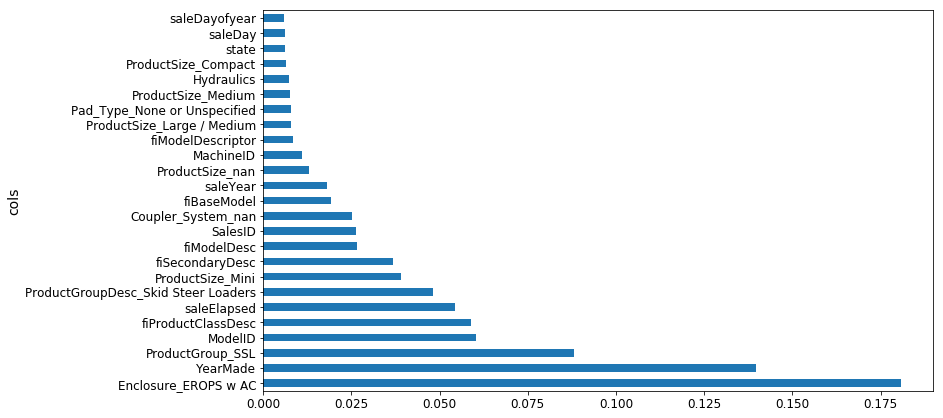

In [33]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

Even though our model yeilded slight worse results, for feature importance one-hot encodeing is always important as we see now that Enclosure_EROPS w AC is more important than YearMade.

# Removing redundant features

We’ve already seen how variables which are basically measuring the same thing can confuse our variable importance. They can also make our random forest slightly less good because it requires more computation to do the same thing and there’re more columns to check. So we are going to do some more work to try and remove redundant features. The way I do that is to do something called “dendrogram”. And it is kind of hierarchical clustering.

In [34]:
from scipy.cluster import hierarchy as hc

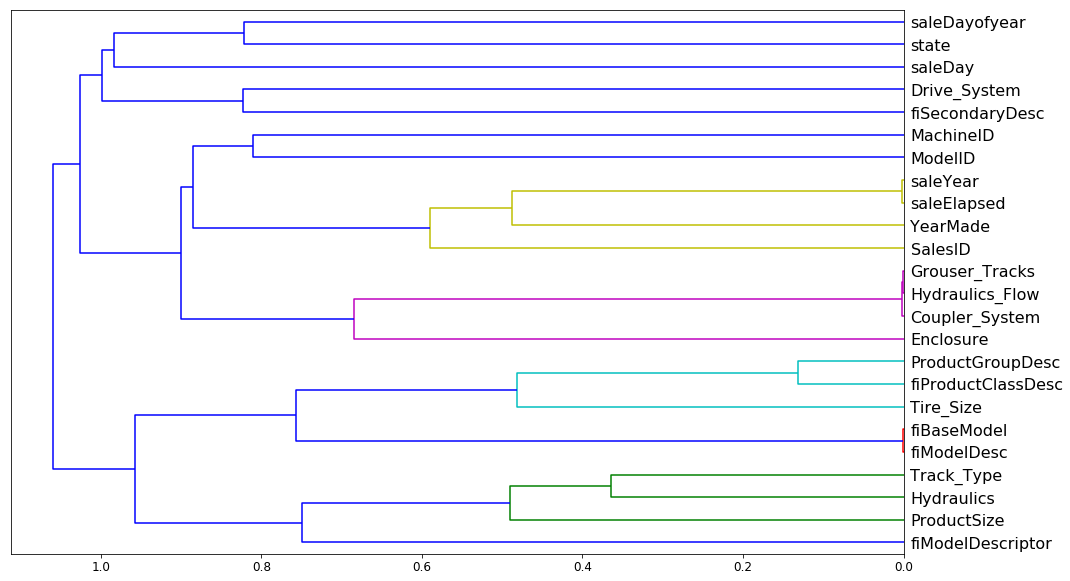

In [35]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Spearman’s R - looking at ranking vs. a field - Convert everything to rank, then calculate the correlation coefficient.

Like so, we can see which two variables are the most similar. `saleYear` and `saleElapsed` are very similar. So the horizontal axis here is how similar are the two points that are being compared. If they are closer to the right, that means that they are very similar. So saleYear and saleElapsed have been combined and they were very similar.

Another way could be a heatmap. However, the above is easier to see. 

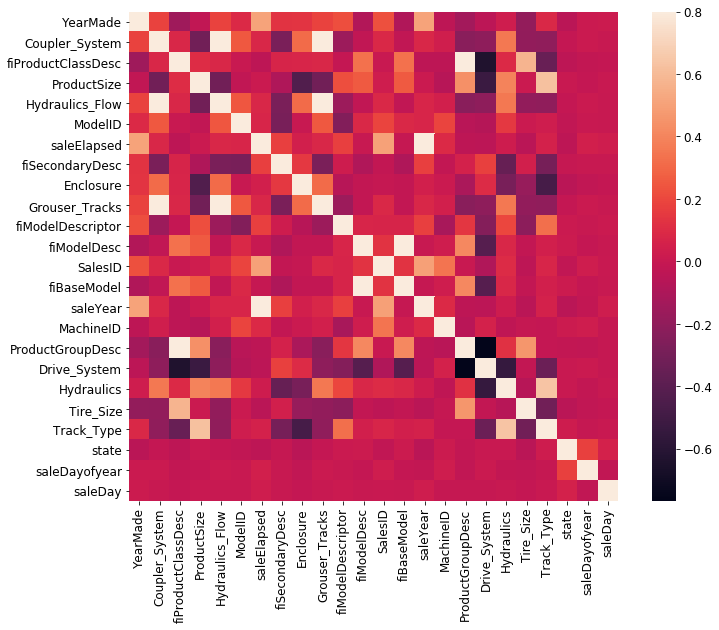

In [55]:
#correlation matrix
corrmat = df_keep.corr(method ="spearman")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [59]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [60]:
get_oob(df_keep)

0.9085978092106016

Now we try removing each variable one at a time.

In [62]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks','Hydraulics_Flow', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.9081874778398795
saleElapsed 0.906246413557008
fiModelDesc 0.9077008247386767
fiBaseModel 0.9079934806992167
Grouser_Tracks 0.9082956159047046
Hydraulics_Flow 0.9087186786187886
Coupler_System 0.9083286216816552


It looks like we can try one from each group for removal. Let's see what that does.

In [63]:
to_drop = ['saleYear', 'fiBaseModel', 'Hydraulics_Flow']
get_oob(df_keep.drop(to_drop, axis=1))

0.9074196704104807

our result is slightly worse but by removing colums we have a more simple model so let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [64]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [65]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [70]:
keep_cols = np.load('tmp/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [72]:
reset_rf_samples()

In [73]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 44s, sys: 36 ms, total: 1min 44s
Wall time: 9.5 s
[0.12599080058360373, 0.22812019738503223, 0.966824880397714, 0.9070658242671265, 0.9085309524531824]


##### Recap: Feature importance - very key for finding top features



- Few features have most of the importance: Find only the feature importances over a certain threshold

- Collinearity distributes importance: random forests deal with collinearity very well, but one by-product is that collinear fields will ‘steal’ importance. The total importance will be distributed between the column.

- Feature filtering will consolidate importance: Feature importance filtering and recalculating will reconsolidate importance in the key fields

- We can also loop an shuffle columns and compare the performance with the column shuffled. It’s a good indicator for finding important features.

# Partial dependence

Really inderstand you data better.

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

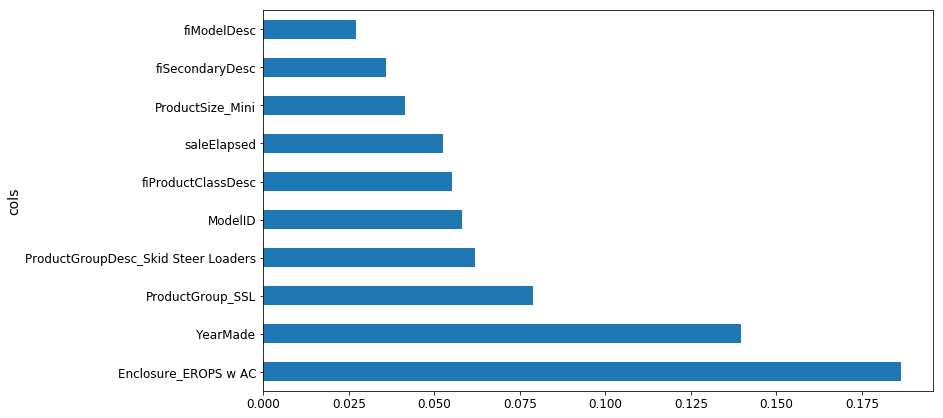

In [ ]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

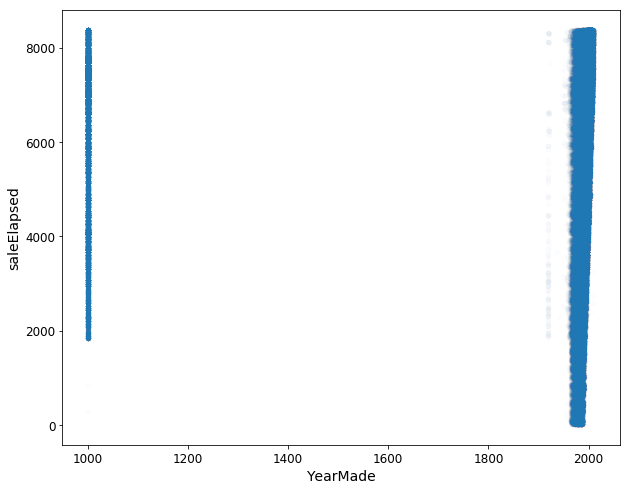

In [ ]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

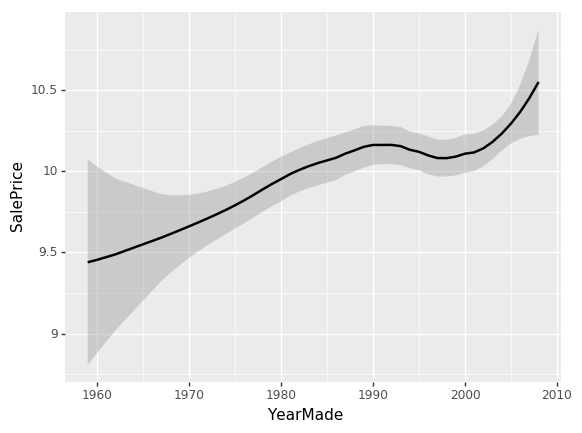

<ggplot: (8729550331912)>

In [ ]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

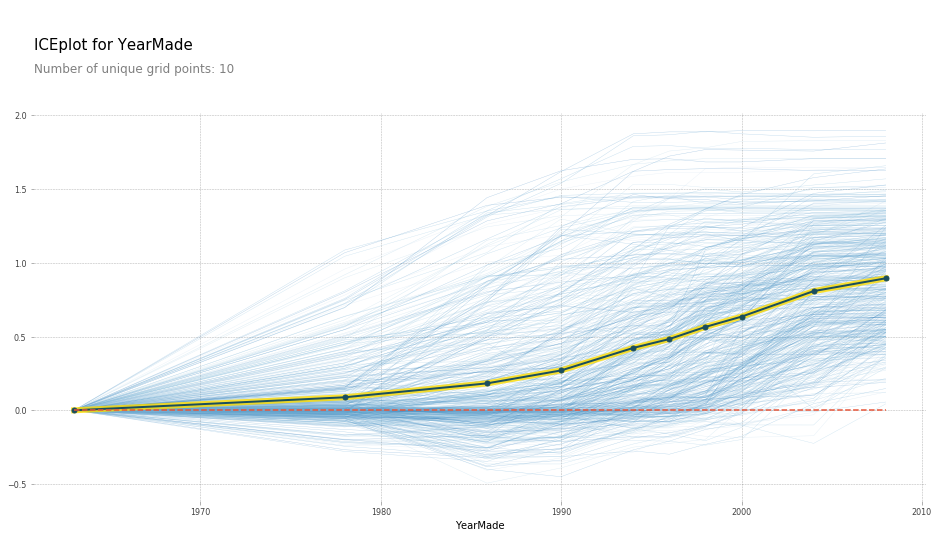

In [ ]:
plot_pdp('YearMade')

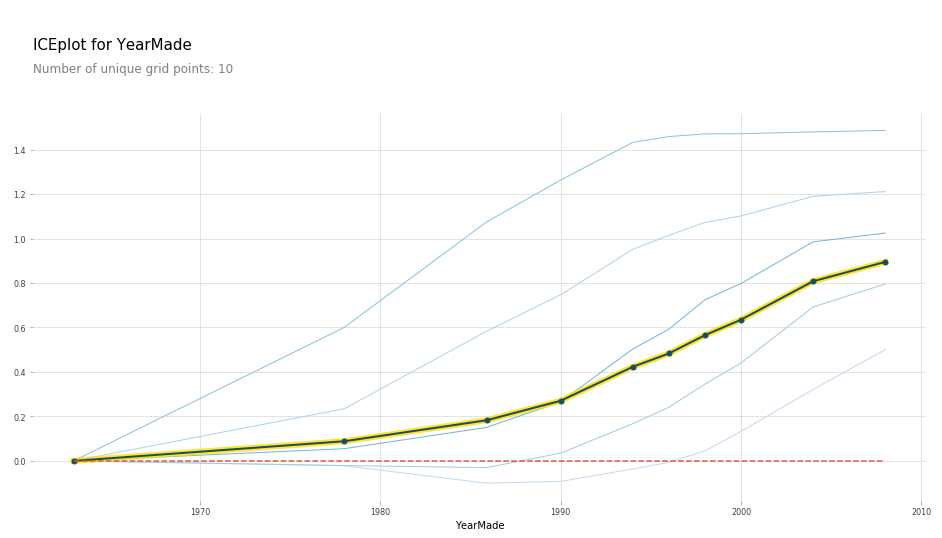

In [ ]:
plot_pdp('YearMade', clusters=5)

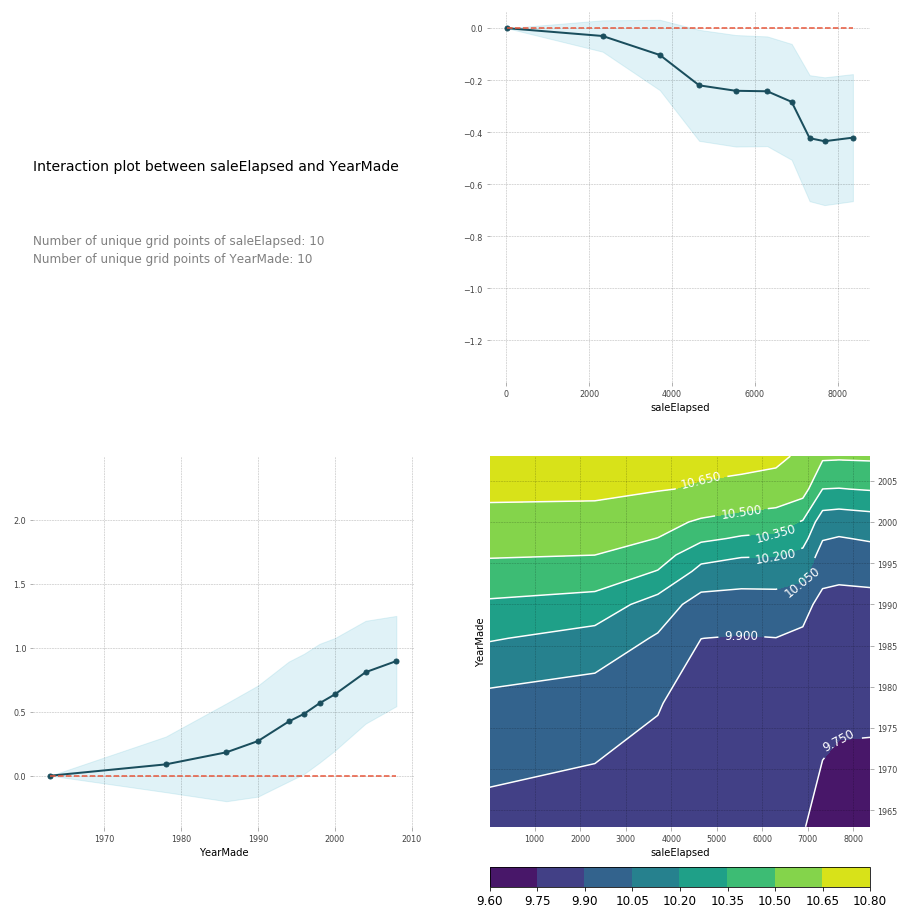

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

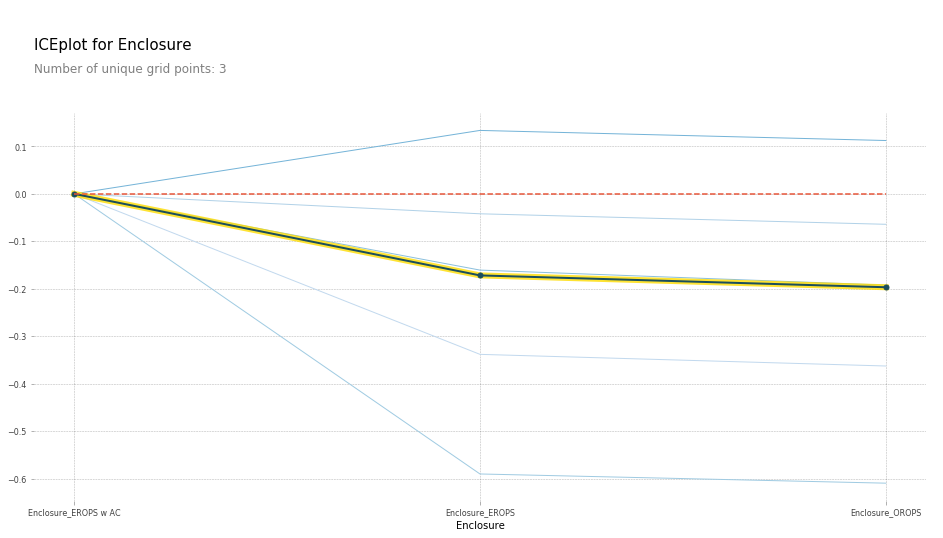

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

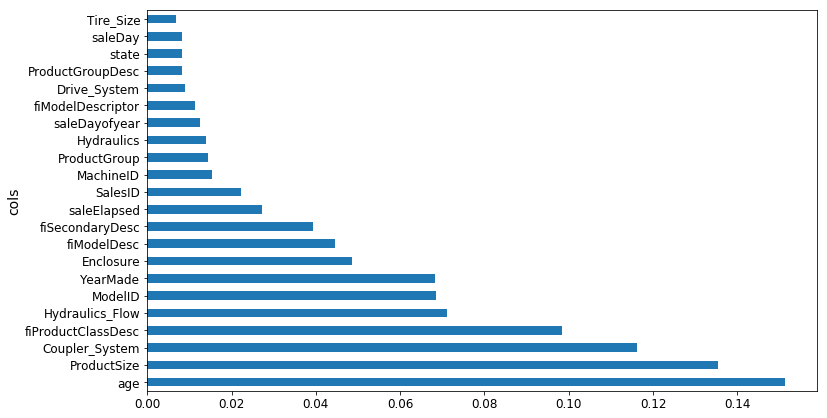

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 3, 3232, 1111, 0, 63, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9, 37,
        16, 3, 259, False, False, False, False, False, False, 7912, False, False]], dtype=object)

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

(9.1909688098736275, 10.10606580677884)

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54680742853695008),
 ('age', 11, -0.12507089451852943),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
 ('fiModelDesc', 'KX1212', -0.065155113754146801),
 ('fiSecondaryDesc', nan, -0.055237427792181749),
 ('Enclosure', 'EROPS', -0.050467175593900217),
 ('fiModelDescriptor', nan, -0.042354676935508852),
 ('saleElapsed', 7912, -0.019642242073500914),
 ('saleDay', 16, -0.012812993479652724),
 ('Tire_Size', nan, -0.0029687660942271598),
 ('SalesID', 4364751, -0.0010443985823001434),
 ('saleDayofyear', 259, -0.00086540581130196688),
 ('Drive_System', nan, 0.0015385818526195915),
 ('Hydraulics', 'Standard', 0.0022411701338458821),
 ('state', 'Ohio', 0.0037587658190299409),
 ('ProductGroupDesc', 'Track Excavators', 0.0067688906745931197),
 ('ProductGroup', 'TEX', 0.014654732626326661),
 ('MachineID', 2300944, 0.015578052196894499),
 ('Hydraulics_Flow', nan, 0.028973749866174004),
 ('ModelID', 665, 0.0383074

In [ ]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [ ]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


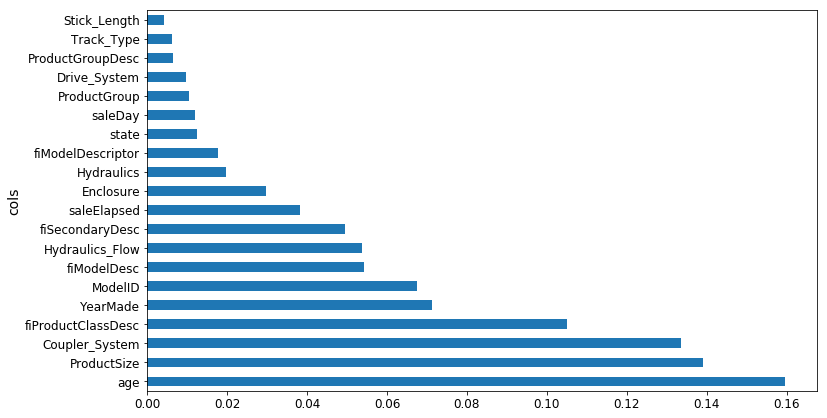

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
